In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [67]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
full_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed")

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

### Cleaning Data

In [68]:

#full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')
# replace Korea, South with South Korea 
full_table['Country/Region'] = full_table['Country/Region'].replace('Korea, South', 'South Korea')



# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
full_table['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [37]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed']]




In [71]:
country = 'Spain'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)



,Confirmed
Date,
2020-03-18,13910
2020-03-19,17963
2020-03-20,20410
2020-03-21,25374
2020-03-22,28768
2020-03-23,35136
2020-03-24,39885
2020-03-25,49515
2020-03-26,57786


In [73]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [74]:
def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, 0]) ** 2

    return math.sqrt(r) 

3288.1647433376147

In [75]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
opt

array([5.67681816e+06, 3.03849085e-02, 2.98196941e+01])

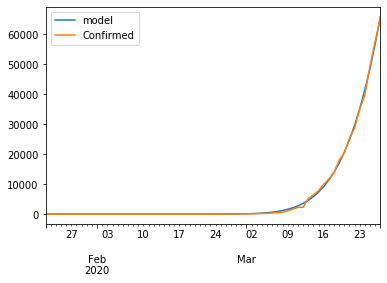

In [76]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['model']
pd.concat([model_sim, df], axis=1).plot()
plt.show()

let's extend the prediction curve

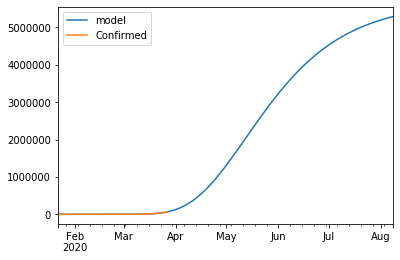

In [79]:
import datetime
start_date = df.index[0]
n_days = 200
extended_model_x = []
for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)
extended_model_sim.columns = ['model']
pd.concat([extended_model_sim, df], axis=1).plot()
plt.show()

let's display predictions for future weeks

In [144]:
df

,Confirmed US
Date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
2020-01-27,5
2020-01-28,5
2020-01-29,5
2020-01-30,5


In [81]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 3 == 0].astype({'model': 'int32'})

,Confirmed,model
2020-01-24,0,0
2020-01-27,0,0
2020-01-30,0,0
2020-02-03,1,0
2020-02-06,1,0
2020-02-09,2,0
2020-02-12,2,0
2020-02-15,2,0
2020-02-18,2,0
2020-02-21,2,1


now let's compare the dynamic in different countries

In [46]:
def display_fit(df, opt, ax):
    model_x = []
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt, t)])
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['model']
    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))

def display_extended_curve(df, opt, ax):
    start_date = df.index[0]
    n_days = 110
    extended_model_x = []
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt, t)])
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['model']
    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(12, 8))



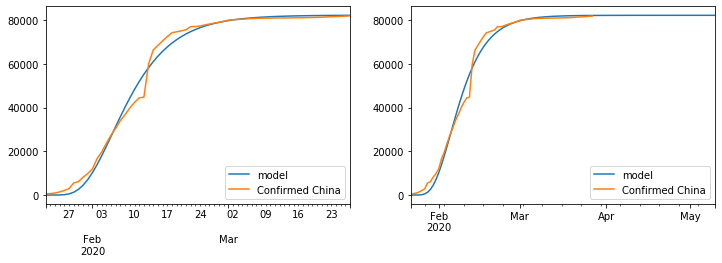

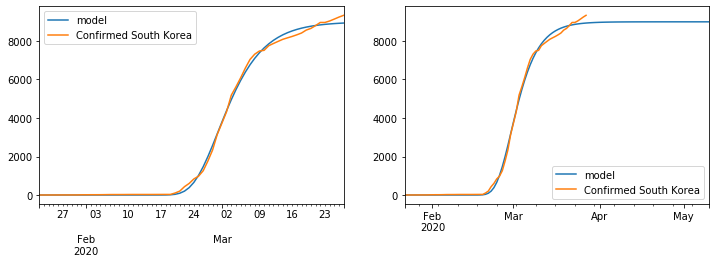

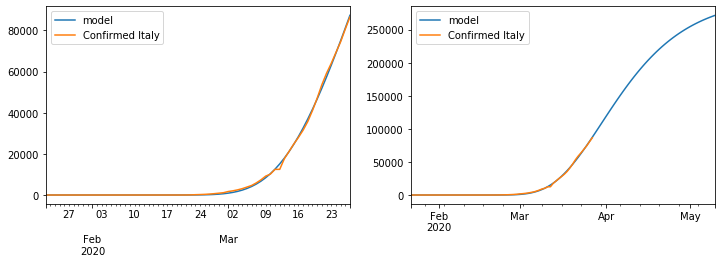

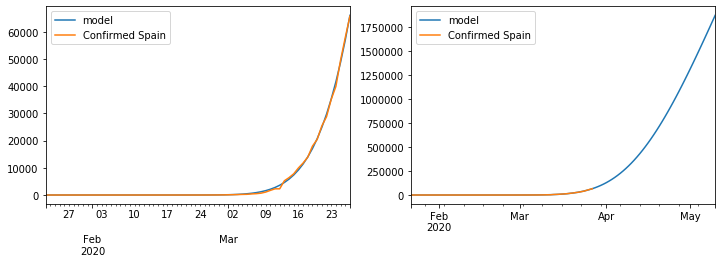

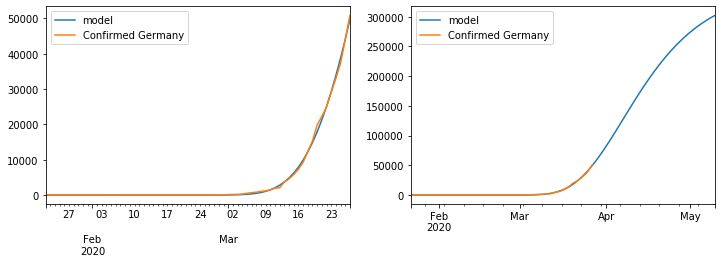

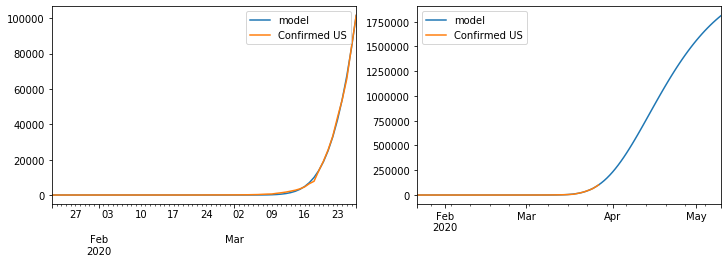

,Country,Projected Number of Cases,Yesterdays Confirmed Cases,Yesterdays Growth Rate,Two Days Ago Growth Rate,Three Days Ago Growth Rate
0,China,"82,222.6866",81897,0.9504,1.7286,0.7527
1,South Korea,"8,993.7453",9332,0.8750,1.0400,1.3158
2,Italy,"298,505.1989",86498,0.9526,1.1906,0.9926
3,Spain,"5,676,818.1610",65719,0.9591,0.8589,2.0278
4,Germany,"347,768.7186",50871,1.0481,1.5252,1.1036
5,US,"2,223,671.1431",101657,0.9869,1.5001,1.2168


In [150]:
# Country Specify
# do it for China, South Korea, Italy, Spain, Germany, USA
stats = []
for Country in [ 'China','South Korea','Italy','Spain','Germany','US']:
# for country in ['Sweden']:
    df = get_time_series(Country)

    df.columns = [df.columns[0] + ' ' + Country]
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)

    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    lastg =((df.iloc[-1]-df.iloc[-2])/(df.iloc[-2]-df.iloc[-3]))[0]
    dayb = ((df.iloc[-2]-df.iloc[-3])/(df.iloc[-3]-df.iloc[-4]))[0]
    daybb = ((df.iloc[-3]-df.iloc[-4])/(df.iloc[-4]-df.iloc[-5]))[0]
    yconcas = (df.iloc[-1])[0]
# print(country, opt)
    if min(opt) > 0:
        stats.append([Country, *opt,yconcas,lastg,dayb,daybb ])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt, ax2)
        plt.show()
stats_df = pd.DataFrame(stats)
stats_df.columns = ['Country', 'Projected Number of Cases', 'a', 'alpha','Yesterday''s Confirmed Cases','Yesterday''s Growth Rate','Two Day''s Ago Growth Rate','Three Day''s Ago Growth Rate']
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'Projected Number of Cases': 'int'}).sort_values(by='Projected Number of Cases', ascending=False)
stats_df[['Country','Projected Number of Cases','Yesterday''s Confirmed Cases','Yesterdays Growth Rate','Two Days Ago Growth Rate','Three Days Ago Growth Rate']]


In [139]:
df

,Confirmed US
Date,
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
2020-01-27,5
2020-01-28,5
2020-01-29,5
2020-01-30,5


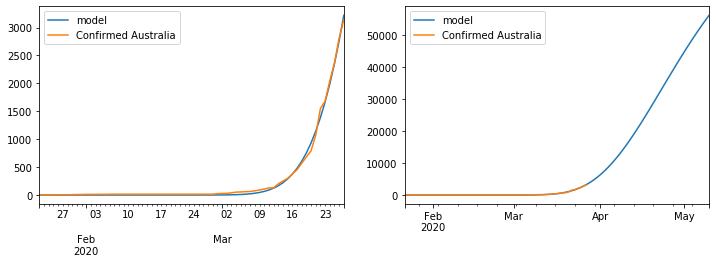

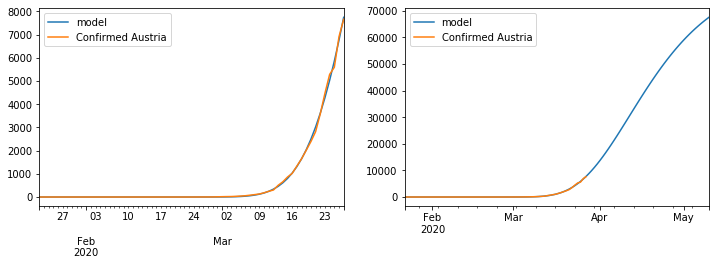

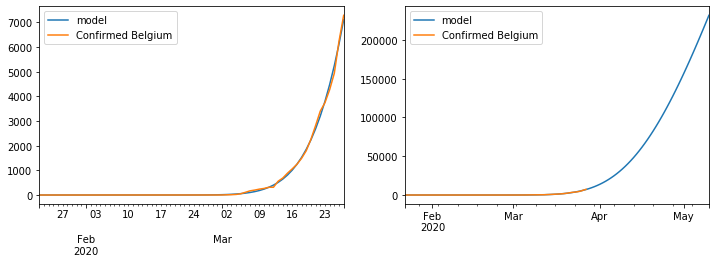

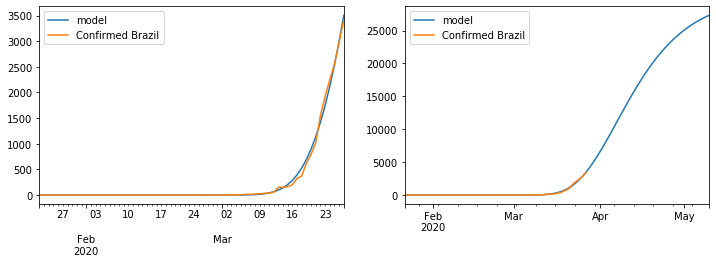

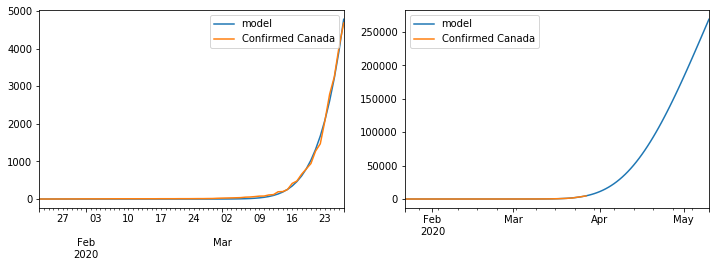

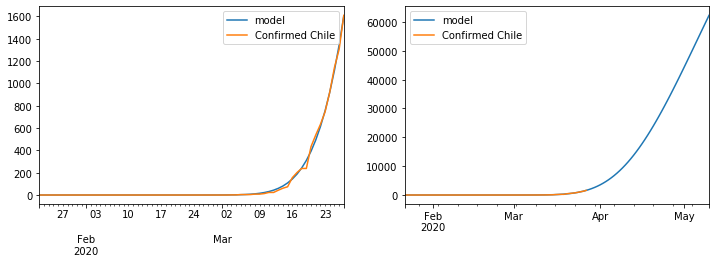

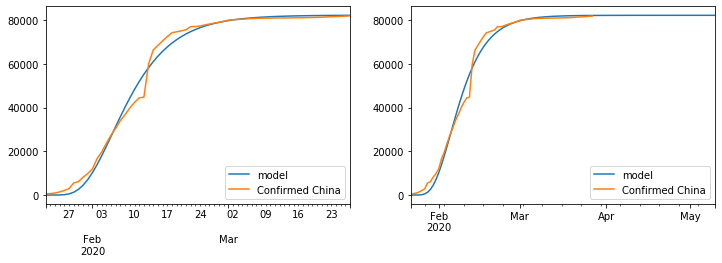

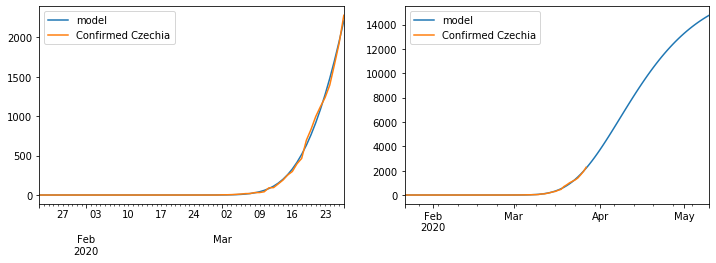

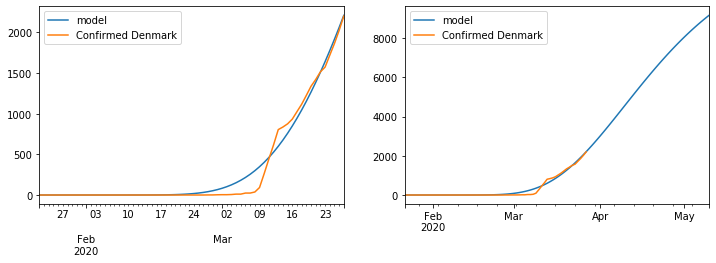

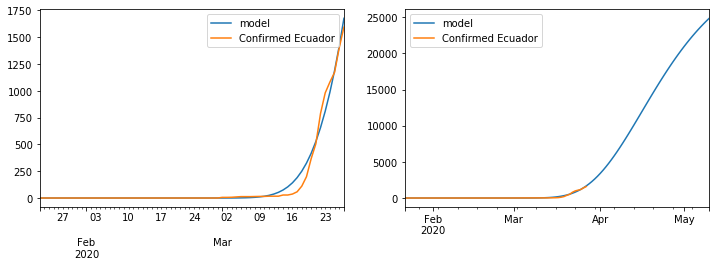

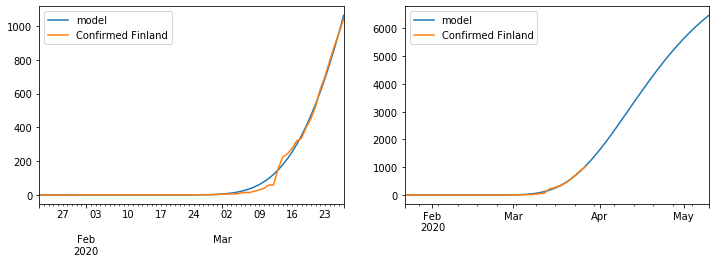

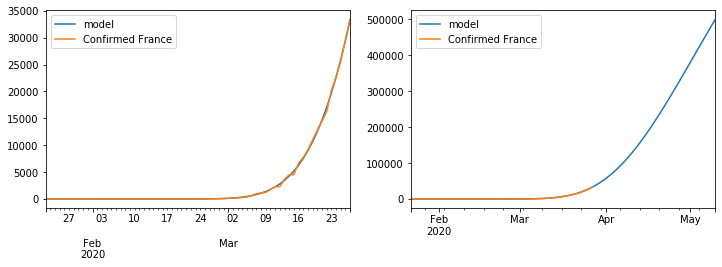

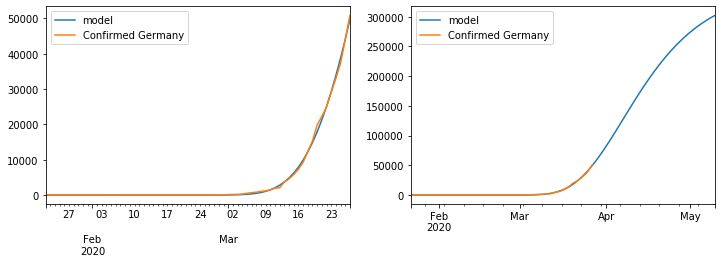

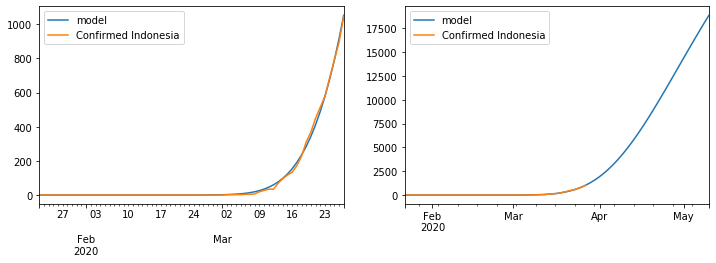

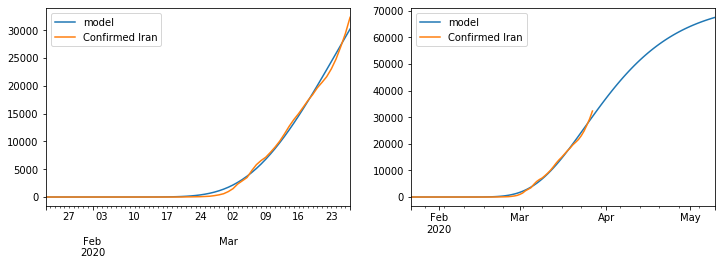

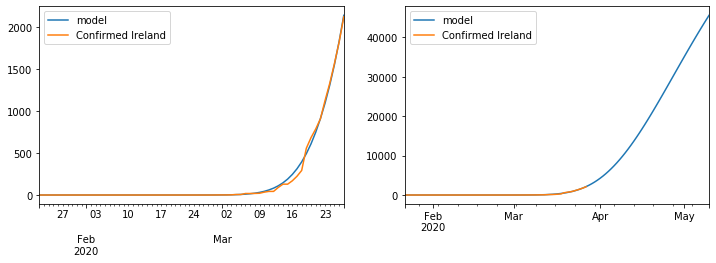

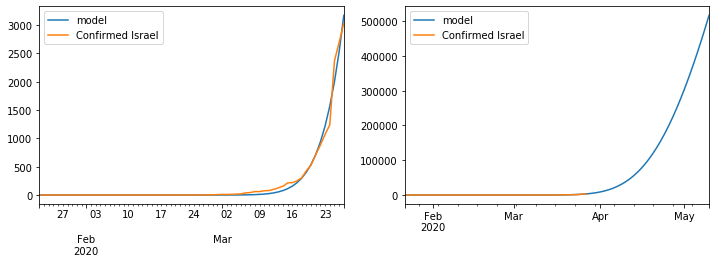

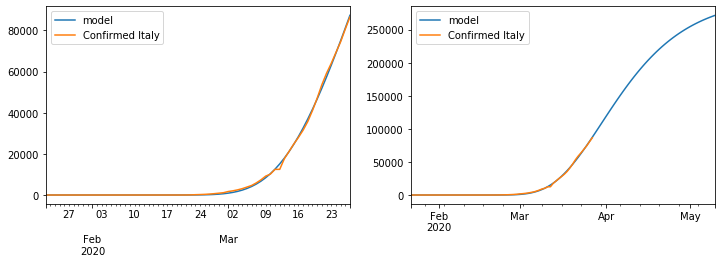

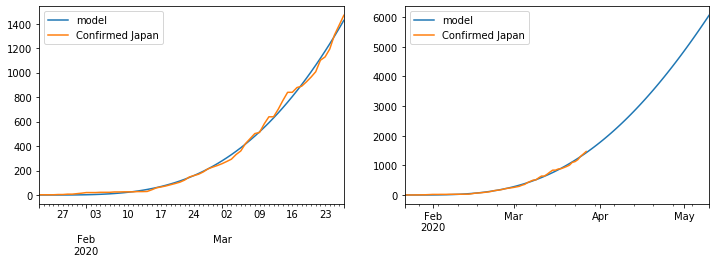

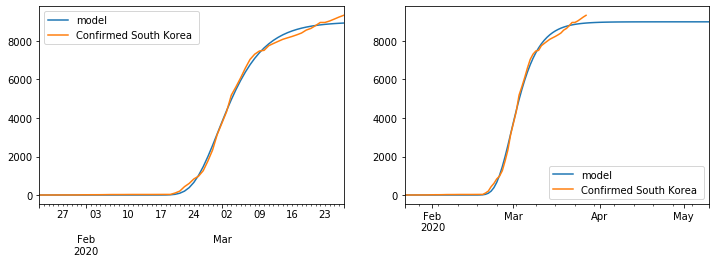

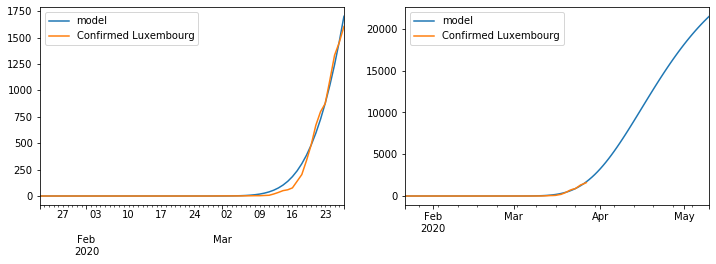

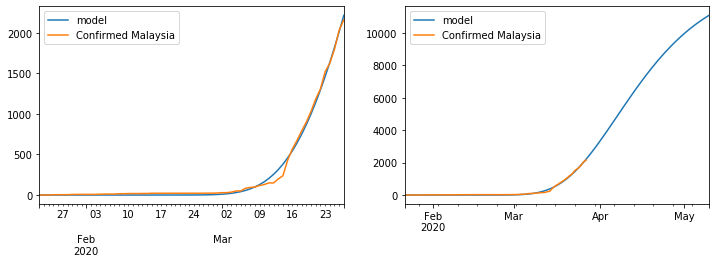

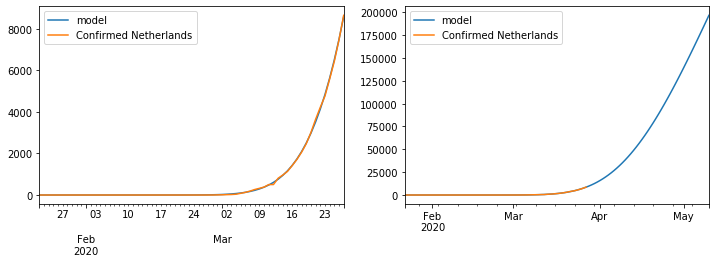

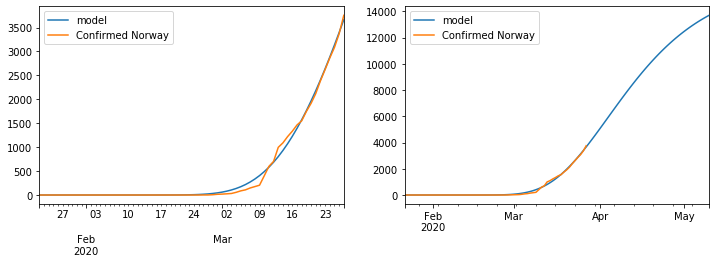

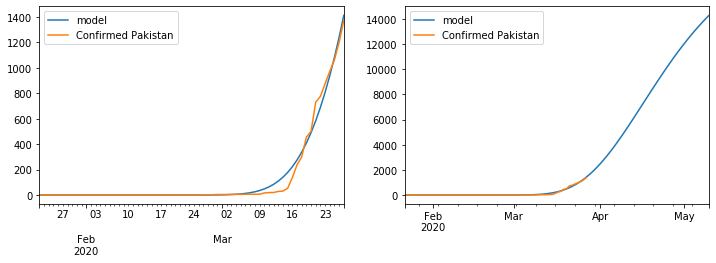

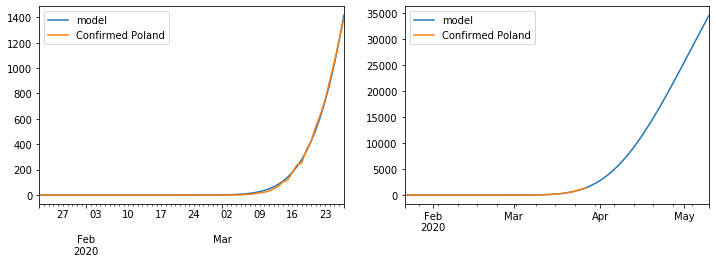

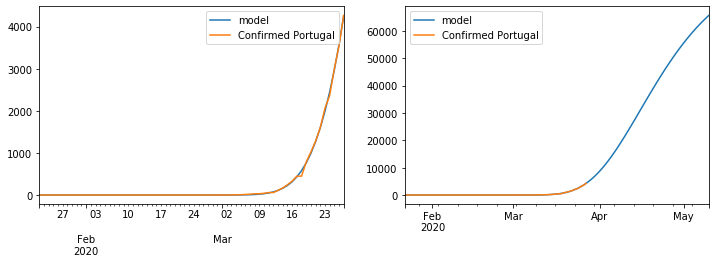

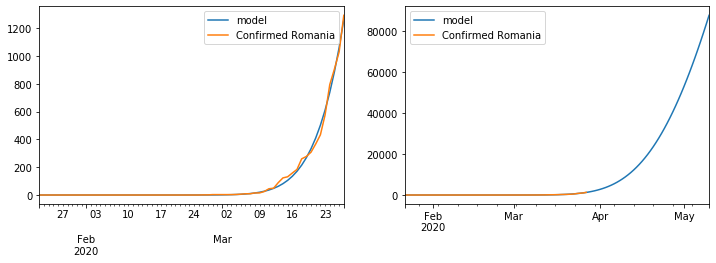

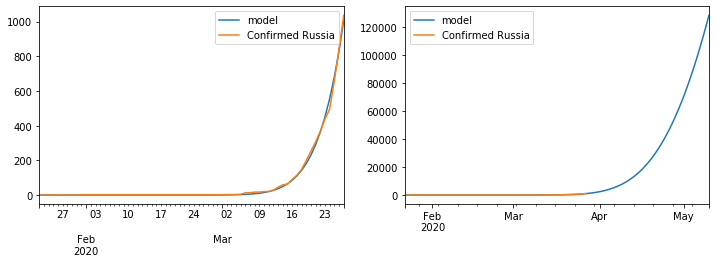

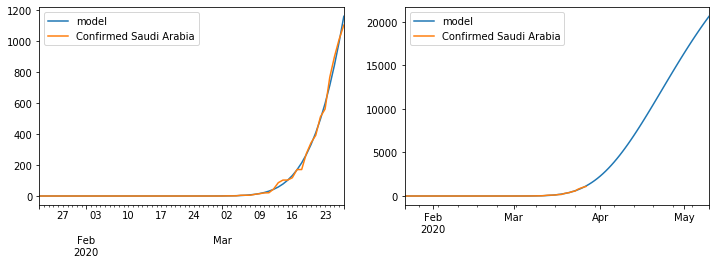

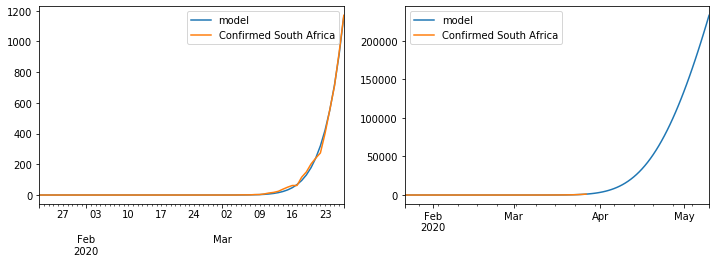

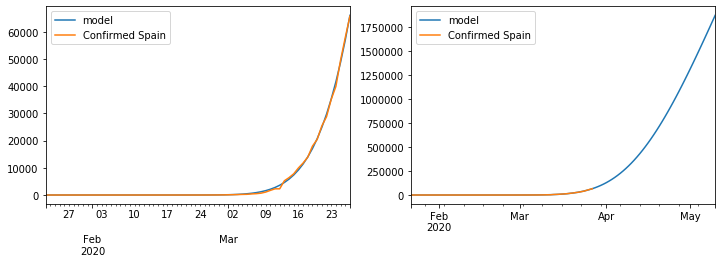

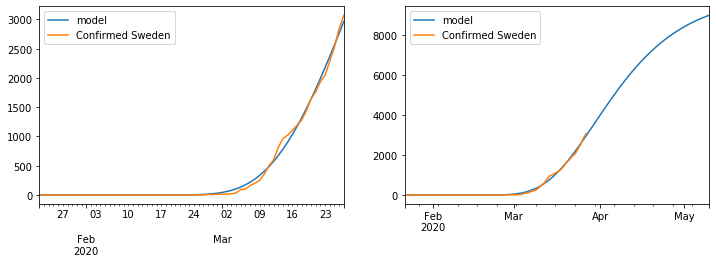

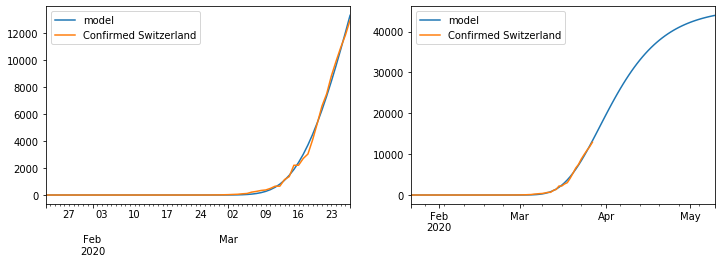

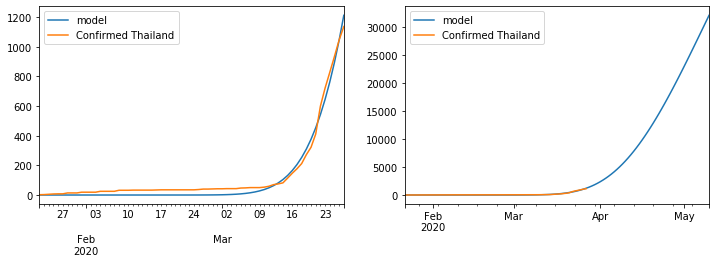

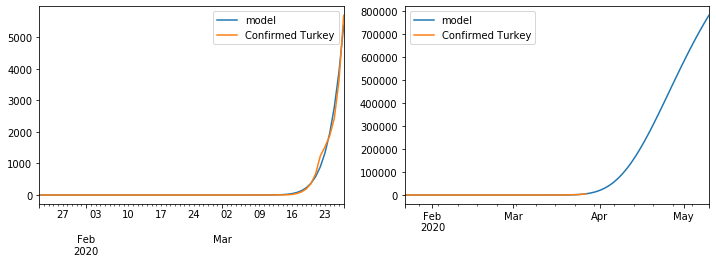

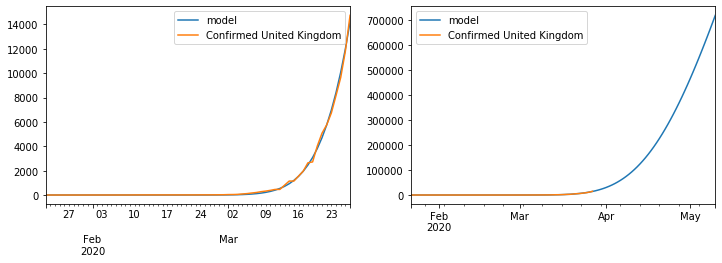

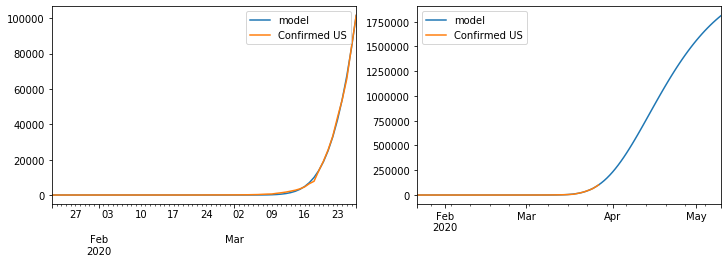

In [50]:
# All Country Confirmed Greater than 1000
# do it for China, South Korea, Italy, Spain, Germany, USA

stats = []
for country in full_table['Country/Region'].unique():

    df = get_time_series(country)
    # only consider countries with at least 1000 cases 
    if len(df) == 0 or (max(df['Confirmed']) < 1000): 
        continue
    df.columns = [df.columns[0] + ' ' + country]
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
#     print(country, opt)
    if min(opt) > 0:
        stats.append([country, *opt])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt, ax2)
        plt.show()
stats_df = pd.DataFrame(stats)
# stats_df.columns = ['country', 'N', 'a', 'alpha', 'lag']
stats_df.columns = ['country', 'N', 'a', 'alpha']

we can see above that China and Korea are reaching a plateau, Iran is in the middle phase, while the other countries are in the exponential part of the curve

N is the potential spread in the country if the dynamics since the beginning of the epidemy persist. One problem is that sometimes we're measuring the spread of testing rather than of the epidemy. For instance New York allegedly started tesing a lot of people, which might explain the current explosive dynamic in the US numbers.